In [ ]:
from google.colab import drive

# Mount on Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Change directory to project folder
os.chdir("/content/drive/MyDrive/CS547/DeepDiveProject/Dataset")

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

## Load and Prepare Data


In [ ]:
# Load working dataset
working_data = pickle.load(open("working_dataset.pkl", "rb"))
working_data

,Date,Gasoline Prices (Dollars per Gallon),Net Imports (Thousand Barrels per Day)
0,1993-04-05/1993-04-11,1.068,7970
1,1993-04-12/1993-04-18,1.079,6990
2,1993-04-19/1993-04-25,1.079,7729
3,1993-04-26/1993-05-02,1.086,8437
4,1993-05-03/1993-05-09,1.086,7086
...,...,...,...
1641,2024-09-16/2024-09-22,3.307,-2798
1642,2024-09-23/2024-09-29,3.311,-2829
1643,2024-09-30/2024-10-06,3.303,-3015
1644,2024-10-07/2024-10-13,3.260,-3412


In [ ]:
# Convert Date to numeric values (number of days since a fixed date)
working_data['Date_numeric'] = working_data['Date'].dt.start_time.map(lambda x: x.toordinal())

# Define features (X) and target variable (y)
X = working_data[['Date_numeric', 'Net Imports (Thousand Barrels per Day)']]
y = working_data['Gasoline Prices (Dollars per Gallon)']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Our Deep Dearning Model


Activations:   0%|          | 0/4 [00:00<?, ?it/s]

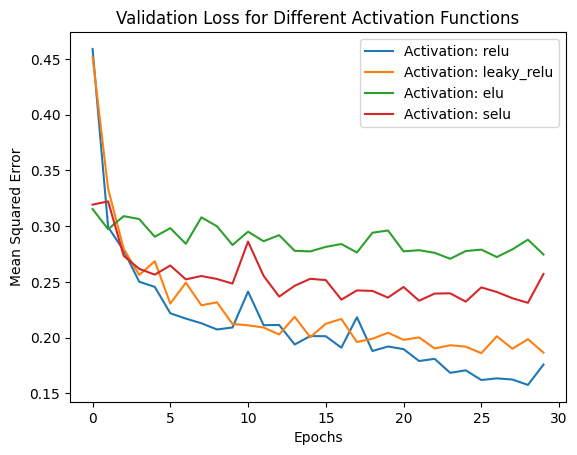

The best activation is relu with an average validation loss of 0.1710 in the last 10 epochs.


In [ ]:
# Test different activation functions
activations = ['relu', 'leaky_relu', 'elu', 'selu']
losses = {}
min_loss = float('inf')
best_activation = None

for activation in tqdm(activations, desc='Activations'):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation=activation),
        Dropout(0.2),
        Dense(64, activation=activation),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=30,
                       batch_size=16, validation_split=0.2,
                       verbose=0)
    losses[activation] = history.history['val_loss']

    # Calculate the average of the last N epochs to determine the best batch size
    last_N_epochs = 10
    average_loss = np.mean(history.history['val_loss'][-last_N_epochs:])
    if average_loss < min_loss:
        min_loss = average_loss
        best_activation = activation

# Plot results
for activation, val_loss in losses.items():
    plt.plot(val_loss, label=f'Activation: {activation}')

plt.title('Validation Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Print the best activation and corresponding loss
print(f"The best activation is {best_activation} with an average validation loss of {min_loss:.4f} in the last {last_N_epochs} epochs.")

## Investigate effects of mini-batch learning


Batch Sizes:   0%|          | 0/4 [00:00<?, ?it/s]

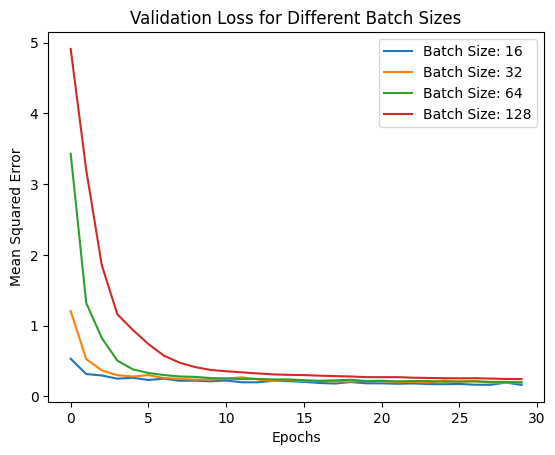

The best batch size is 16 with an average validation loss of 0.1732 in the last 10 epochs.


In [ ]:
batch_sizes = [16, 32, 64, 128]
losses = {}
min_loss = float('inf')
best_batch_size = None

for batch in tqdm(batch_sizes, desc='Batch Sizes'):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch, validation_split=0.2, verbose=0)
    losses[batch] = history.history['val_loss']

    # Calculate the average of the last N epochs to determine the best batch size
    last_N_epochs = 10
    average_loss = np.mean(history.history['val_loss'][-last_N_epochs:])
    if average_loss < min_loss:
        min_loss = average_loss
        best_batch_size = batch

# Plotting the results
for batch, val_loss in losses.items():
    plt.plot(val_loss, label=f'Batch Size: {batch}')

plt.title('Validation Loss for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Print the best batch size and corresponding loss
print(f"The best batch size is {best_batch_size} with an average validation loss of {min_loss:.4f} in the last {last_N_epochs} epochs.")

## Investigate effects of different optimizers


Optimizers:   0%|          | 0/3 [00:00<?, ?it/s]

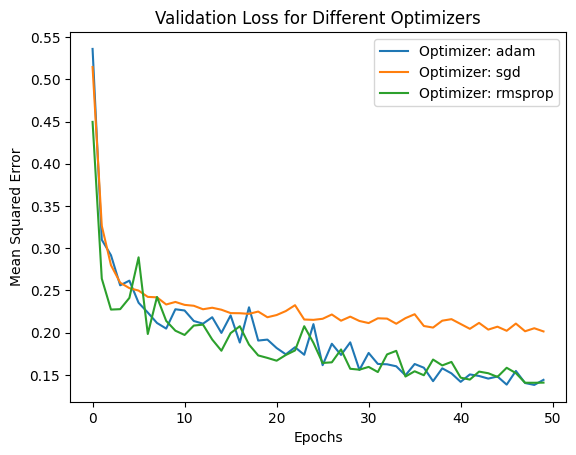

The best optimizer is adam with an average validation loss of 0.1450 in the last 10 epochs.


In [ ]:
optimizers = ['adam', 'sgd', 'rmsprop']

optimizer_results = {}
min_loss = float('inf')
best_optimizer = None


for opt in tqdm(optimizers, desc='Optimizers'):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=opt, loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    optimizer_results[opt] = history.history['val_loss']

    # Calculate the average of the last N epochs to determine the best optimizer
    last_N_epochs = 10
    average_loss = np.mean(history.history['val_loss'][-last_N_epochs:])
    if average_loss < min_loss:
        min_loss = average_loss
        best_optimizer = opt

# Plotting the results
for opt, val_loss in optimizer_results.items():
    plt.plot(val_loss, label=f'Optimizer: {opt}')

plt.title('Validation Loss for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Print the best optimizer and corresponding loss
print(f"The best optimizer is {best_optimizer} with an average validation loss of {min_loss:.4f} in the last {last_N_epochs} epochs.")

## Performance of optimal model

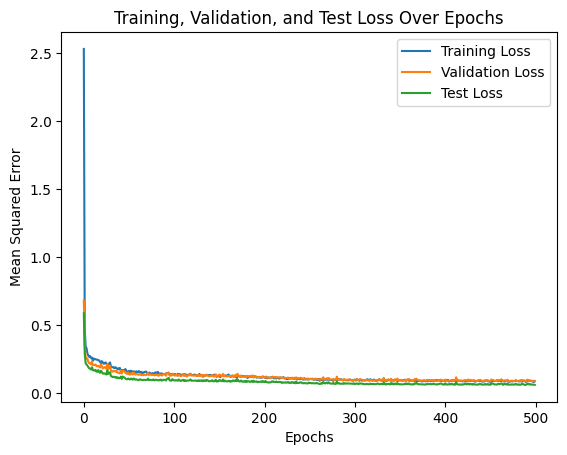

In [ ]:
# Define the model
optimal_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])

# Compile the model
optimal_model.compile(optimizer='adam', loss='mean_squared_error')

# Initialize lists to store losses
train_losses = []
val_losses = []
test_losses = []

# Train the model for each epoch and record losses
epochs = 500
batch_size = 16

for epoch in range(epochs):
    # Fit for one epoch and save training/validation loss
    history = optimal_model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Record the training and validation loss
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate and record the test loss
    test_loss = optimal_model.evaluate(X_test, y_test, verbose=0)
    test_losses.append(test_loss)

# Plot the training, validation, and test loss over epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
y_pred = optimal_model.predict(X_test)

# Calculate Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error (MAE): {test_mae}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Mean Absolute Error (MAE): 0.1553671316984928


## Hyperparameter Tuning Report

### Introduction
This section covers the tuning of key hyperparameters for our regression model aimed at predicting Gasoline Prices based on Net Imports. We focus on `activation`, `batch size`, and `optimizer` as these have substantial impacts on model convergence and performance.

### Experiment Setup
Hyperparameters tested:
- **Activation**: ReLU, LeakyReLU, ELU, SELU
- **Batch Size**: 16, 32, 64, 128
- **Optimizer**: Adam, SGD, RMSprop

### Conclusions
Optimal settings were found to be an activation of ReLU, a batch size of 16, and an Adam optimizer, achieving the lowest validation loss with reasonable computational resources. Larger batch sizes tended to reduce training time but were less effective at minimizing validation loss.